In [1]:
import pandas as pd

#biliotecas para extração e visualização do FFT ou Periodogram (PSD) 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 880 entries, 0 to 879
Data columns (total 55 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   defect_type         880 non-null    object 
 1   rot_vel             880 non-null    float64
 2   ac1ax_0h            880 non-null    float64
 3   ac1ax_1h            880 non-null    float64
 4   ac1ax_2h            880 non-null    float64
 5   ac1ax_3h            880 non-null    float64
 6   ac1ax_entropy       880 non-null    float64
 7   ac1ax_kurt          880 non-null    float64
 8   ac1ax_mean          880 non-null    float64
 9   ac1rad_0h           880 non-null    float64
 10  ac1rad_1h           880 non-null    float64
 11  ac1rad_2h           880 non-null    float64
 12  ac1rad_3h           880 non-null    float64
 13  ac1rad_entropy      880 non-null    float64
 14  ac1rad_kurt         880 non-null    float64
 15  ac1rad_mean         880 non-null    float64
 16  ac1tg_0h

In [3]:
# Criando lista de nomes para cada tipo de valor
columns = list(df.columns)
harmonico0 = [col for col in columns if '0h' in col]
harmonico1 = [col for col in columns if '1h' in col]
harmonico2 = [col for col in columns if '2h' in col]
harmonico3 = [col for col in columns if '3h' in col]
entropias = [col for col in columns if 'entropy' in col]
curtoses = [col for col in columns if 'kurt' in col]
medias = [col for col in columns if 'mean' in col]

In [4]:
# mapeando velocidade em valores categóricos
df['fundamental_decimal'] = (pd.cut(df['fundamental'], bins=[0,15,25,35,45,55,65], labels=False)+1)*10

### Provando a precisão da velocidade obtida pelo FFT do tacômetro

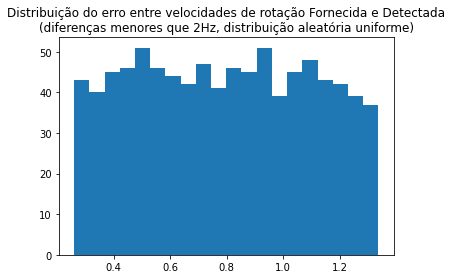

In [91]:
# distribuição do erro
plt.hist(df['rot_vel']-df['fundamental'],20)
plt.title('Distribuição do erro entre velocidades de rotação Fornecida e Detectada'+ 
          '\n(diferenças menores que 2Hz, distribuição aleatória uniforme)')
plt.show()

### Checagem de outliers e valores espúrios

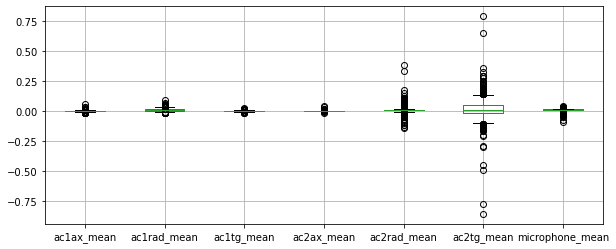

In [5]:
df[medias].boxplot(figsize=(10,4))
plt.show()

### Correlação entre 'médias' e 'transformada em f = 0'

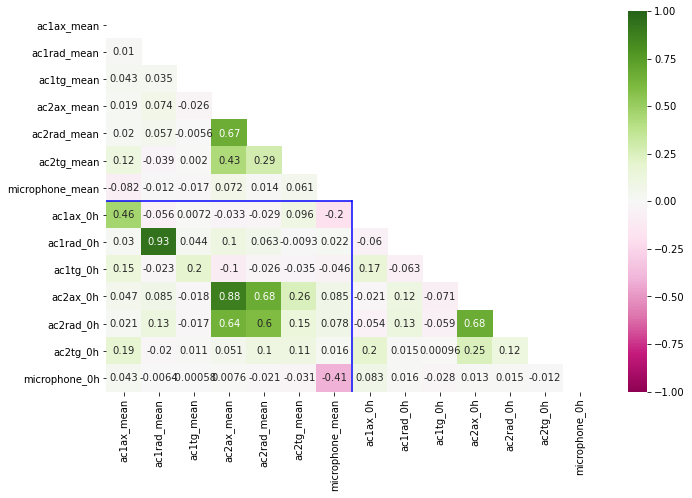

In [6]:
fig, ax = plt.subplots(figsize=(11,7)) 
corr = df[medias+harmonico0].corr()

mask = np.zeros(corr.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

sns.heatmap(corr, vmin = -1, vmax = 1, center = 0, cmap = 'PiYG', annot = True, mask = mask)
plt.plot([0, 7], [7,  7], c='b')
plt.plot([7, 7], [7, 14], c='b')

plt.show()

# Separação de cada conjunto de defeitos

In [7]:
df['defect_type'].value_counts()

imbalance    333
ver_mis      301
hor_mis      197
normal        49
Name: defect_type, dtype: int64

In [8]:
df_normal = df[df['defect_type'] == 'normal'].copy()
df_normal = df_normal.drop(['defect_type', 'rot_vel', 'hor_mis', 'ver_mis', 'imbalance'], axis=1)
# df_normal.info()

# Desbalanceamento

### *Corrigir para plotar valor absoluto*

In [5]:
df_imbalance = df[df['defect_type'] == 'imbalance'].copy()
df_imbalance = df_imbalance.drop(['defect_type', 'rot_vel', 'hor_mis', 'ver_mis'], axis=1)
# df_imbalance.info()

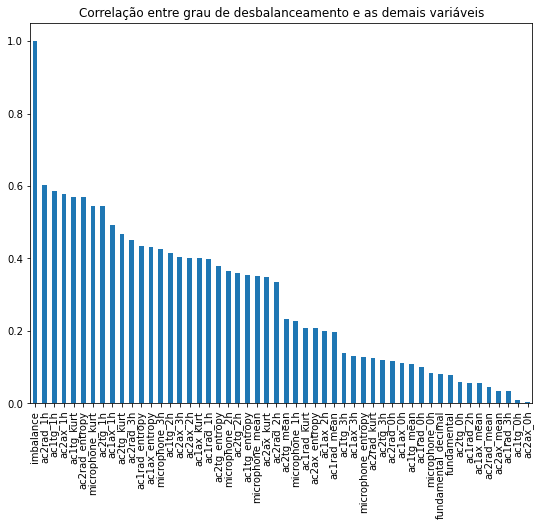

In [14]:
fig, ax = plt.subplots(figsize=(9,7)) 
corr = df_imbalance.corr().abs()['imbalance']
corr.sort_values(ascending=False).plot.bar()
plt.title('Correlação entre grau de desbalanceamento e as demais variáveis')
plt.show()

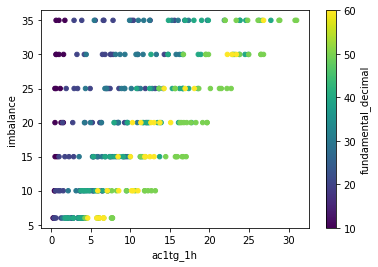

In [72]:
df_imbalance.plot(kind = 'scatter', y = 'imbalance', x = 'ac1tg_1h', c='fundamental_decimal', cmap = 'viridis', sharex = False)
plt.show()

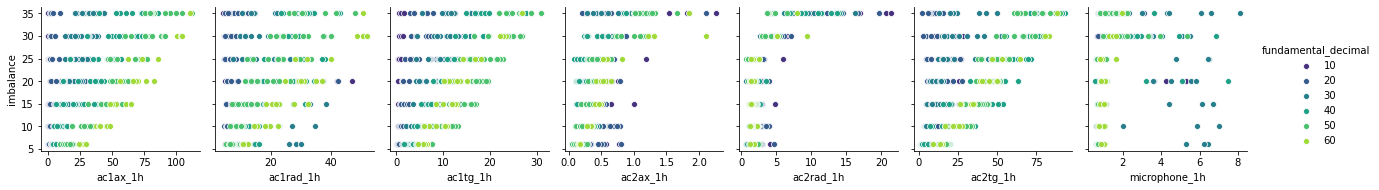

In [76]:
import seaborn as sns
sns.pairplot(df_imbalance, y_vars=['imbalance'], x_vars=harmonico1, hue='fundamental_decimal', palette='viridis')
plt.show()

## *Discretizar a velocidade e plotar linhas*

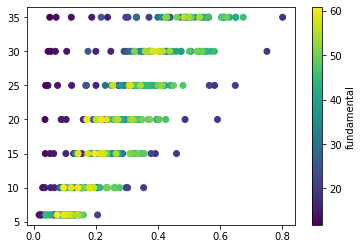

In [74]:
# normalizando com 1/fundamental
plt.scatter(y = df_imbalance['imbalance'], x = df_imbalance['ac1tg_1h']/df_imbalance['fundamental'], c=df_imbalance['fundamental'])
plt.colorbar(label = 'fundamental')
plt.show()

# Desalinhamento vertical

In [80]:
df_ver_mis = df[df['defect_type'] == 'ver_mis'].copy()
df_ver_mis = df_ver_mis.drop(['defect_type', 'rot_vel', 'hor_mis', 'imbalance'], axis=1)
# df_ver_mis.info()

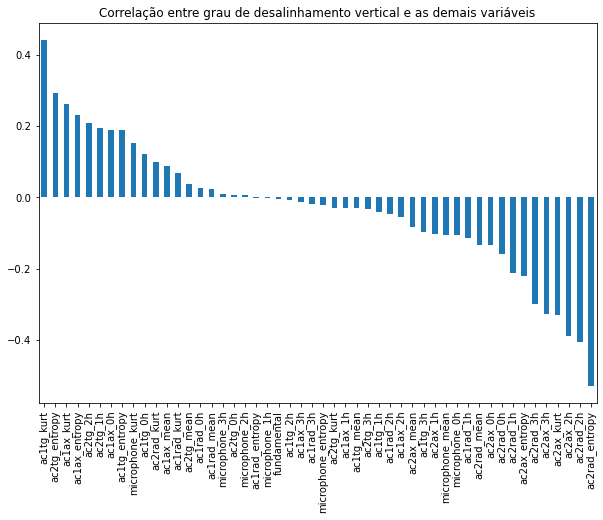

In [27]:
fig, ax = plt.subplots(figsize=(10,7)) 
corr = df_ver_mis.corr()['ver_mis'][:-1]
corr.sort_values(ascending=False).plot.bar()
plt.title('Correlação entre grau de desalinhamento vertical e as demais variáveis')
plt.show()

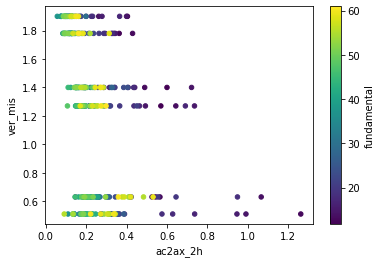

In [18]:
df_ver_mis.plot(kind = 'scatter', y = 'ver_mis', x = 'ac2ax_2h', c='fundamental', cmap = 'viridis', sharex = False)
plt.show()

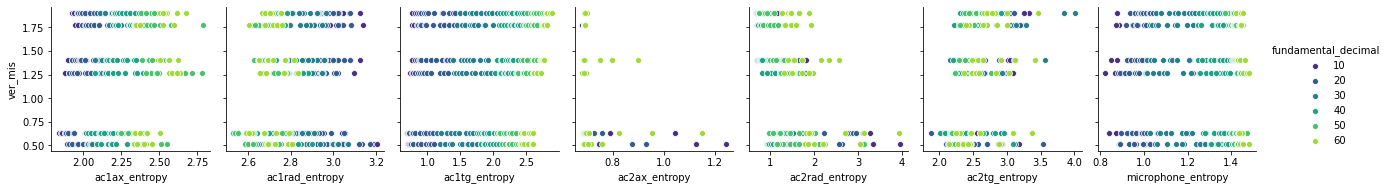

In [84]:
sns.pairplot(df_ver_mis, y_vars=['ver_mis'], x_vars=entropias, hue='fundamental_decimal', palette='viridis')
plt.show()

# Desalinhamento horizontal

In [77]:
df_hor_mis = df[df['defect_type'] == 'hor_mis'].copy()
df_hor_mis = df_hor_mis.drop(['defect_type', 'rot_vel', 'ver_mis', 'imbalance'], axis=1)
# df_hor_mis.info()

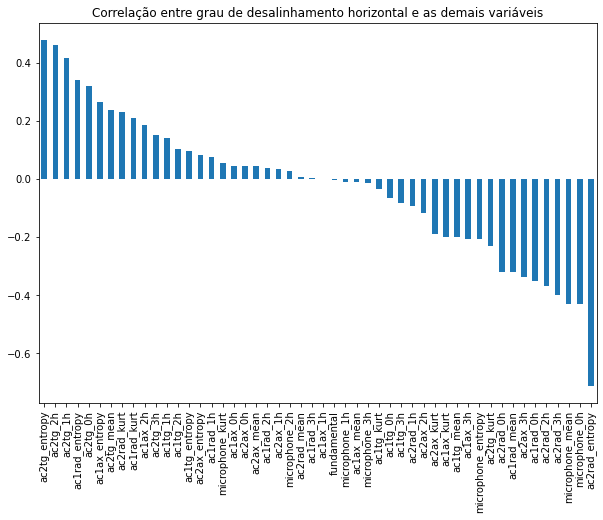

In [25]:
fig, ax = plt.subplots(figsize=(10,7)) 
corr = df_hor_mis.corr()['hor_mis'][:-1]
corr.sort_values(ascending=False).plot.bar()
plt.title('Correlação entre grau de desalinhamento horizontal e as demais variáveis')
plt.show()

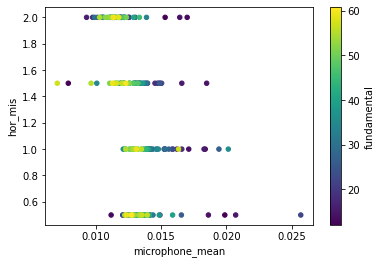

In [57]:
df_hor_mis.plot(kind='scatter', y='hor_mis', x ='microphone_mean', c='fundamental', cmap ='viridis', sharex=False)
plt.show()

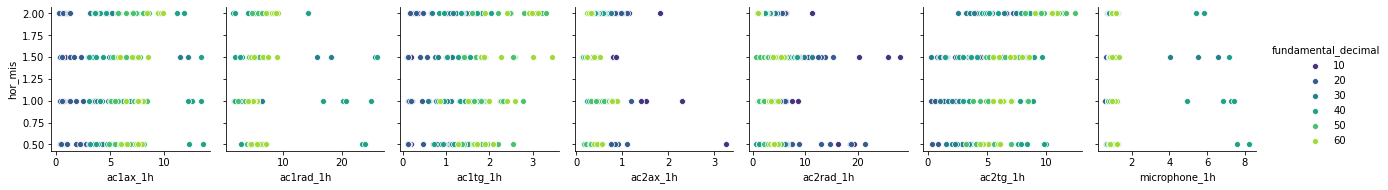

In [79]:
sns.pairplot(df_hor_mis, y_vars=['hor_mis'], x_vars=harmonico1, hue='fundamental_decimal', palette='viridis')
plt.show()